## Regressão simbólica aplicada ao modelo populacional de Gompertz

<p style='text-align: justify'> Nesse Notebook, estamos trabalhando a aplicação da regressão simbólica no modelo populacional de Gompertz, o qual buscamos fazer uma otimização para aproximar soluções de expressões matemáticas de equações diferenciais. Usamos, para isso, a construção de um algoritmo evolutivo. </p>

<p style='text-align: justify'> Para iniciar o nosso processo de regressão, precisamos importar o módulo DEAP do Python, onde temos armanezadas todas as funções e operadores necessários para criar o algoritmo. Além disso, importamos as bibliotecas numpy, sympy, operator. </p>

In [1]:
# Import de bibliotecas 

from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import gompertz, runge_kutta
from funcoes import Div, Exp

### Solução numérica para o modelo dada pelo método de Runge-Kutta

<p style='text-align: justify'> Defnindo os valores de constantes do método de Runge-Kutta, uma vez que queremos comparar o indivíduo gerado pela regressão com a solução numérica definida pelo método de aproximação de Runge-Kutta, o qual é ótimo para aproximar funções. Essa abordagem foi escolhida para uma generalização onde não conhecemos a solução real da EDO, tratando a aproximação por Runge-Kutta como a solução analítica. </p>

In [2]:
T0 = 0  # Tempo inicial
TF = 1  # Tempo final
H = 0.01  # Passo
X0 = 3  # Valor inicial
K = 1  # Constante da equação diferencial

T, X = runge_kutta(gompertz, T0, X0, TF, H, K)

### Algoritmo genético de Regressão simbólica 

Vamos, então, definir as constantes do nosso problema, as quais dizem respeito a quantidade de gerações que queremos otimizar e o tamanho de cada uma.

In [3]:
# CONSTANTES
NUM_GERACOES = 500   # Número de gerações
TAMANHO_POP = 1000   # Tamanho da população
TAMANHO_TORNEIO = 3   # Quantidade de indivíduos que duelam a cada torneio
CHANCE_CRUZAMENTO = 0.5   # Chance de ocorrer cruzamento entre indivíduos
CHANCE_MUTACAO = 0.03   # Chance de ocorrer mutação em um indivíduo

<p style='text-align: justify'> Inicializando a montagem do nosso algoritmo, precisamos definir quais são os genes possíveis para cada indivíduo. Usamos, assim, o PrimitiveSet do DEAP para realizar essa tarefa. </p>

In [4]:
# Definindo os genes pelo PrimiteSet
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

# Adicionando uma constante efêmera no PrimitiveSet de genes, importante para garantir que hajam constantes com valores numéricos
pset.addEphemeralConstant("rand105", lambda: rd.randint(-1,1))

# Renomendo o argumento para a expressão ficar em função de 't'
pset.renameArguments(ARG0='t')

<p style='text-align: justify'> Agora podemos criar uma classe para o cálculo do fitness de acordo com os parâmetros exigidos pelo nosso algoritmo, bem como criar uma classe de indivíduo que será criado baseado na sua profundidade máxima do modelo de árvore primitiva do DEAP. </p>

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Convocando a função de fitness e declarando uma minimização
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)  # Convocando a função que cria o indivíduo a partir do PrimitiveSet
                                                                            # que representam os genes do indivíduo.

<p style='text-align: justify'> Além de podermos registrar as ferramentas que serão utilizadas para realizar as operações de algoritmos evolutivos. Ou seja, estamos definindo a forma como os individuos e a população serão gerados de acordo com as funções operadoras do DEAP. </p>

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)  # Gerando expressões para definir funções e terminais disponíveis
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)  # Registrando a função de criação do indivíduo
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Registrando a função de criação da população
toolbox.register("compile", gp.compile, pset=pset)   # Registrando a função de campilação do indivíduo para torná-lo executável

<p styl='text-align: justify'> Para podermos comparar a regressão e o método de Runge-Kutta, precisamos definir uma função de fitness para calcular o RMSE entre elas. </p>

In [7]:
# Definindo nossa própria função de fitness para gerar o RMSE entre a regressão e a solução numérica (Runge-Kutta)
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

<p styl='text-align: justify'>  </p>

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))  # Registrando uma função de fitness
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)   # Registrando o operador de seleção por torneio
toolbox.register("mate", gp.cxOnePoint)   # Registrando o operador de cruzamento
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)   # Registrando o operador de mutação da árvore para determinar sua profundidade
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)  # Registrando o operador de mutação
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))  # Registrando o tamanho limite do indivíduo gerado pelo cruzamento, dado pela quantidade de genes
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))  # Registrando o tamanho limite do indivíduo gerado pela mutação

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

<p style='text-align: justify'> A seguir, trabalhamos o processo de criação de uma população de indivíduos que possui um tamanho definido anteriormente, os quais são selecionados os melhores pelo Hall da Fama, dado por uma função de registro dos melhores indivíduos encontrados. Isso é feito pela função eaSimple do DEAP, que evolui uma população aplicando os operadores genéticos para criar e selecionar os melhores indivíduos. Essa função recebe como argumentos, portanto, a população, a caixa de ferramentas, as chances de mutação e cruzamento, o número de gerações, o Hall da Fama e um comando de print para dar continuidade no loop. </p>

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                      fitness                      	                  size                 
   	      	---------------------------------------------------	---------------------------------------
gen	nevals	avg        	gen	min    	nevals	std        	avg  	gen	min	nevals	std    
0  	1000  	2.68812e+40	0  	3.38146	1000  	8.49632e+41	3.824	0  	2  	1000  	1.62081
1  	511   	2.68812e+40	1  	3.38146	511   	8.49632e+41	3.711	1  	1  	511   	1.64544
2  	505   	1.53714e+41	2  	1.4593 	505   	2.73559e+42	3.43 	2  	1  	505   	1.60346
3  	504   	inf        	3  	2.31984	504   	nan        	3.367	3  	1  	504   	1.5749 


c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


4  	532   	1.07525e+41	4  	1.4593 	532   	1.69671e+42	3.421	4  	1  	532   	1.59742
5  	526   	2.68812e+40	5  	1.4593 	526   	8.49632e+41	3.605	5  	1  	526   	1.57892
6  	524   	15.2166    	6  	1.4593 	524   	143.384    	3.873	6  	1  	524   	1.51818
7  	477   	inf        	7  	1.4593 	477   	nan        	4.004	7  	1  	477   	1.50797


C:\JupyterLab\REDES NEURAIS\RNAG_Trabalho_Final\funcoes.py:92: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\SOPHIA~1\AppData\Local\Temp/ipykernel_10828/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


8  	500   	38342.9    	8  	1.4593 	500   	1.21159e+06	4.073	8  	1  	500   	1.54715
9  	483   	9.60258    	9  	1.4593 	483   	17.2024    	4.149	9  	1  	483   	1.62444
10 	513   	43495.8    	10 	1.43475	513   	1.22232e+06	4.232	10 	1  	513   	1.65111
11 	551   	inf        	11 	1.43475	551   	nan        	4.545	11 	1  	551   	1.87403
12 	537   	inf        	12 	1.26304	537   	nan        	4.834	12 	1  	537   	1.99109
13 	489   	inf        	13 	1.26304	489   	nan        	5.188	13 	1  	489   	2.17822
14 	518   	inf        	14 	1.26304	518   	nan        	5.508	14 	1  	518   	2.33322
15 	545   	inf        	15 	1.26304	545   	nan        	5.688	15 	1  	545   	2.45981
16 	545   	inf        	16 	1.26304	545   	nan        	5.798	16 	1  	545   	2.55014
17 	491   	inf        	17 	1.26304	491   	nan        	5.877	17 	1  	491   	2.49236
18 	494   	inf        	18 	1.26304	494   	nan        	6.172	18 	1  	494   	2.84331
19 	520   	inf        	19 	1.06357	520   	nan        	6.736	19 	1  	520   	3.06567
20 	

<p style='text-align: justify'> O valor do RMSE é retornado na sequência de loops gerada acima, podendo ser visto nos dados referentes ao fitness, mais especificamente, na coluna de nome "min", referente a minimização do fitness. </p>

<p styl='text-align: justify'> Assim, finalmente obtendo as expressões retornadas pelo algoritmo, criamos um for loop para printar os indivíduos que foram armazenados no Hall da Fama, em que o primeiro da lista é o melhor indivíduo encontrado. </p>

In [11]:
for i in hof.items:
    print(str(i))
    print()

Exp(Exp(mul(t, add(Div(1, Exp(Exp(t))), neg(1)))))

Exp(Exp(mul(t, add(-1, Div(1, Exp(Exp(t)))))))

Exp(Exp(mul(add(Div(1, Exp(Exp(t))), -1), t)))

Exp(Exp(mul(t, add(Div(1, Exp(Exp(t))), -1))))

Exp(Exp(mul(t, add(-1, Div(Exp(-1), Exp(t))))))



### Reportando o melhor individuo encontrado

<p style='text-align: justify'> Esse reporte foi feito para obtermos um resultado gráfico para que haja uma comparação clara entre os dois métodos. Portanto, estamos definindo o melhor indivíduo e plotando ele juntamento com a solução por Runge-Kutta. </p>

Exp(Exp(mul(t, add(Div(1, Exp(Exp(t))), neg(1)))))


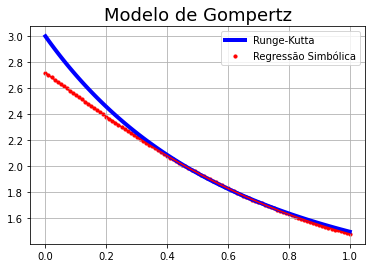

In [12]:
# Definindo o melhor indivíduo
melhor_individuo = str(hof.items[0])  # o melhor indivíduo é o primeiro apresentado na lista printada do Hall da Fama
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)  # Compilando esse indivíduo em um executável
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)

# Plotando o gráfico
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Gompertz', size = 18)
ax.plot(T, X, label = 'Runge-Kutta', c = 'b', linewidth = 4)
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', c = 'r', s = 10)
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('resultados\Resultado_Gompertz_1.png', dpi = 200)

<p style='text-align: justify'> Como obtivemos uma representação da expressão como uma string, ou seja, de maneira simbólica, queremos transformá-la em uma representação numérica. Fazemos isso usando o código a seguir. </p>

In [13]:
# Definindo as funções para computar a representação simbólico utilizando o sympy
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

# Usando um novo PrimitiveSet para definir os operadores matemáticos
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)

# Novamente adicionando a constante efêmera
new_pset.addEphemeralConstant("rand106", lambda: rd.randint(-1,1))

# Renomeando o argumento para que seja representado em função do tempo
new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)  # Registrando a função de compilação do indivíduo numérico

In [14]:
func = toolbox.compile(expr=melhor_individuo)  # Compilando o indivíduo em um executável

# Definindo os símbolos como terminais
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

<p style='text-align: justify'> Ao final, temos a nossa  </p>

In [15]:
display(sp.expand(func(t)))

exp(exp(-t)*exp(t*exp(-exp(t))))